<a href="https://colab.research.google.com/github/KimGriezmann/DeepLearning_BeTheLegend/blob/master/mlp_2021data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **데이터 크롤링으로 가져오기**

In [ ]:
def data_crawling(year, num_top_batter=9):
  # Parameter
  # 원하는 연도 입력
  year = year
  # 데이터를 수집할 타자 중 타석 수 상위 명수
  num_top_batter = 9

  # Team List
  # 원하는 연도에 등록된 팀을 미리 넣어두어야함 (추가 가능)
  Team_2016 = ['NC','kt','LG','두산','히어로즈','KIA','롯데','삼성','SK','한화']
  Team_2017 = ['NC','kt','LG','두산','히어로즈','KIA','롯데','삼성','SK','한화']
  Team_2018 = ['NC','kt','LG','두산','히어로즈','KIA','롯데','삼성','SK','한화']
  Team_2019 = ['NC','kt','LG','두산','키움','KIA','롯데','삼성','SK','한화']
  Team_2020 = ['NC','kt','LG','두산','키움','KIA','롯데','삼성','SK','한화']
  Team_2021 = ['kt','삼성','LG','SSG','NC','키움','두산','롯데','KIA','한화']

  # Team Dictionary
  # Team List를 딕셔너리에 넣음 (추가 가능)
  TeamDic = {'2016':Team_2016, '2017':Team_2017, '2018':Team_2018, '2019':Team_2019, '2020':Team_2020, '2021':Team_2021}

  ###############
  # BeautifulSoup

  import numpy as np
  import pandas as pd
  import requests
  from bs4 import BeautifulSoup
  from tqdm import tqdm

  # 데이터를 모을 dataframe 생성
  data = pd.DataFrame(columns=['name','날짜', '상대', '결과', '타순', 'P', '선발', '타수', '득점', '안타', '2타', '3타', '홈런', '루타', '타점', '도루', '도실',
                              '볼넷', '사구', '고4', '삼진', '병살', '희타', '희비', 'avg', '출루', '장타', 'OPS', '투구', 'avLI', 'RE24', 'WPA'])

  batter_data = pd.DataFrame(columns=['Team','name'])

  for Team in tqdm(TeamDic[str(year)]): # 선택한 연도의 팀을 하나씩 가져옴
    
    # 스탯티즈 시즌기록실 페이지에서 연도, 팀 선택하고, 타석순으로 정렬
    wp = requests.get("http://www.statiz.co.kr/stat.php?opt=0&sopt=0&re=0&ys=" + str(year) + "&ye=" + str(year) + "&se=0&te=" + Team + "&tm=&ty=0&qu=auto&po=0&as=&ae=&hi=&un=&pl=&da=1&o1=TPA&o2=TPA&de=1&lr=0&tr=&cv=&ml=1&sn=30&si=&cn=")
    soup = BeautifulSoup(wp.text, "html.parser")
    
    # 현재 팀의 타석 수 상위 num_top_batter 명
    tmp_batter_list = np.empty(num_top_batter,dtype=object)
    tmp_team = np.array([Team]*num_top_batter) # 타석 수 상위 타자 팀명 저장
    tmp_batter_list_href = np.empty(num_top_batter,dtype=object)
    tmp_batter_ps=0
    for batter in soup.find_all('tr')[2:11]:
      tmp_batter_list[tmp_batter_ps] = batter.find_all('td')[1].text # 타석 수 상위 타자 이름 저장
      tmp_batter_list_href[tmp_batter_ps] = batter.find_all('a')[0].attrs['href'] # 타석 수 상위 타자 주소 저장
      tmp_batter_ps+=1

    batter_data = pd.concat([batter_data, pd.DataFrame({'Team':tmp_team, 'name':tmp_batter_list})])

    # 타석 수 상위 타자들 중 한명씩 데이터를 모으는 과정
    for top_batter in range(num_top_batter):
      wp=requests.get("http://www.statiz.co.kr/"+tmp_batter_list_href[top_batter]) # 타자 주소로 접근
      soup=BeautifulSoup(wp.text, "html.parser")

      # 날짜별 데이터로 접근
      href_byDate = soup.select('body > div > div.content-wrapper > div > section.content > div > div:nth-of-type(1) > div > div.col-xs-12.col-sm-8.col-md-8.col-lg-12 > div > div.table-responsive.no-padding.box > table')[0].find_all('a')[3].attrs['href']
      wp=requests.get("http://www.statiz.co.kr/"+href_byDate)
      soup=BeautifulSoup(wp.text,"html.parser")

      # year : 원하는 연도로 접근
      href_byDate_year=soup.select('body > div.wrapper > div.content-wrapper > div > section.content > div > div:nth-of-type(2) > div > div:nth-of-type(2) > div')[0].find('a', text=str(year)).attrs['href']
      wp=requests.get("http://www.statiz.co.kr/"+href_byDate_year)
      soup=BeautifulSoup(wp.text,"html.parser")

      ## 데이터가 있는 페이지로 이동 완료
      ## 이제 실질적인 데이터를 모을 차례
      rawdata=soup.select('body > div > div.content-wrapper > div > section.content > div > div:nth-of-type(2) > div > div:nth-of-type(3) > div > div > table')[0]
      # rawdata : 전체 테이블

      # th를 제외한 순수한 경기 데이터 / th는 컬럼명 행이다.
      rawdata_not_th = rawdata.find_all('tr',{'class':['oddrow_stz0','evenrow_stz0']})

      # 행렬만들기
      rawdata_name = np.array([tmp_batter_list[top_batter]]*len(rawdata_not_th))
      rawdata_day = np.zeros(len(rawdata_not_th), dtype=object)
      rawdata_vs_team = np.zeros(len(rawdata_not_th), dtype=object)
      rawdata_result = np.zeros(len(rawdata_not_th), dtype=object)
      rawdata_bat_order = np.zeros(len(rawdata_not_th),dtype=np.int_)
      rawdata_position = np.zeros(len(rawdata_not_th), dtype=object)
      rawdata_start_memeber = np.zeros(len(rawdata_not_th), dtype=np.bool)
      rawdata_ab = np.zeros(len(rawdata_not_th), dtype=np.int_)
      rawdata_score = np.zeros(len(rawdata_not_th), dtype=np.int_)
      rawdata_hit = np.zeros(len(rawdata_not_th), dtype=np.int_)
      rawdata_2_hit = np.zeros(len(rawdata_not_th), dtype=np.int_)
      rawdata_3_hit = np.zeros(len(rawdata_not_th), dtype=np.int_)
      rawdata_homerun = np.zeros(len(rawdata_not_th), dtype=np.int_)
      # 영어명으로 변경 필요
      rawdata_루타 = np.zeros(len(rawdata_not_th), dtype=np.int_)
      rawdata_타점 = np.zeros(len(rawdata_not_th), dtype=np.int_)
      rawdata_도루 = np.zeros(len(rawdata_not_th), dtype=np.int_)
      rawdata_도실 = np.zeros(len(rawdata_not_th), dtype=np.int_)
      rawdata_볼넷 = np.zeros(len(rawdata_not_th), dtype=np.int_)
      rawdata_사구 = np.zeros(len(rawdata_not_th), dtype=np.int_)
      rawdata_고4 = np.zeros(len(rawdata_not_th), dtype=np.int_)
      rawdata_삼진 = np.zeros(len(rawdata_not_th), dtype=np.int_)
      rawdata_병살 = np.zeros(len(rawdata_not_th), dtype=np.int_)
      rawdata_희타 = np.zeros(len(rawdata_not_th), dtype=np.int_)
      rewdata_희비 = np.zeros(len(rawdata_not_th), dtype=np.int_)
      rawdata_avg = np.zeros(len(rawdata_not_th), dtype=np.float)
      rawdata_출루 = np.zeros(len(rawdata_not_th), dtype=np.float)
      rawdata_장타 = np.zeros(len(rawdata_not_th), dtype=np.float)
      rawdata_ops = np.zeros(len(rawdata_not_th), dtype=np.float)
      rawdata_투구 = np.zeros(len(rawdata_not_th), dtype=np.int_)
      rawdata_avLI = np.zeros(len(rawdata_not_th), dtype=np.float)
      rawdata_RE24 = np.zeros(len(rawdata_not_th), dtype=np.float)
      rawdata_WPA = np.zeros(len(rawdata_not_th), dtype=np.float)

      for rawdata_not_th_tr_index in range(len(rawdata_not_th)):
        # 한 행 : rawdata_not_th_tr_index
        rawdata_not_th_td = [text for text in rawdata_not_th[rawdata_not_th_tr_index].stripped_strings]
        # 현재 행의 하나의 값 : rawdata_not_th_td[index]
        # 데이터 입력
        rawdata_day[rawdata_not_th_tr_index] = rawdata_not_th_td[1]
        rawdata_vs_team[rawdata_not_th_tr_index] = rawdata_not_th_td[2]
        rawdata_result[rawdata_not_th_tr_index] = rawdata_not_th_td[3]+" "+rawdata_not_th_td[4]
        rawdata_bat_order[rawdata_not_th_tr_index] = rawdata_not_th_td[5]
        rawdata_position[rawdata_not_th_tr_index] = rawdata_not_th_td[6]
        rawdata_start_memeber[rawdata_not_th_tr_index] = rawdata_not_th_td[7]
        rawdata_ab[rawdata_not_th_tr_index] = rawdata_not_th_td[8]
        rawdata_score[rawdata_not_th_tr_index] = rawdata_not_th_td[9]
        rawdata_hit[rawdata_not_th_tr_index] = rawdata_not_th_td[10]
        rawdata_2_hit[rawdata_not_th_tr_index] = rawdata_not_th_td[11]
        rawdata_3_hit[rawdata_not_th_tr_index] = rawdata_not_th_td[12]
        rawdata_homerun[rawdata_not_th_tr_index] = rawdata_not_th_td[13]
        rawdata_루타[rawdata_not_th_tr_index] = rawdata_not_th_td[14]
        rawdata_타점[rawdata_not_th_tr_index] = rawdata_not_th_td[15]
        rawdata_도루[rawdata_not_th_tr_index] = rawdata_not_th_td[16]
        rawdata_도실[rawdata_not_th_tr_index] = rawdata_not_th_td[17]
        rawdata_볼넷[rawdata_not_th_tr_index] = rawdata_not_th_td[18]
        rawdata_사구[rawdata_not_th_tr_index] = rawdata_not_th_td[19]
        rawdata_고4[rawdata_not_th_tr_index] = rawdata_not_th_td[20]
        rawdata_삼진[rawdata_not_th_tr_index] = rawdata_not_th_td[21]
        rawdata_병살[rawdata_not_th_tr_index] = rawdata_not_th_td[22]
        rawdata_희타[rawdata_not_th_tr_index] = rawdata_not_th_td[23]
        rewdata_희비[rawdata_not_th_tr_index] = rawdata_not_th_td[24]
        rawdata_avg[rawdata_not_th_tr_index] = rawdata_not_th_td[25]
        rawdata_출루[rawdata_not_th_tr_index] = rawdata_not_th_td[26]
        rawdata_장타[rawdata_not_th_tr_index] = rawdata_not_th_td[27]
        rawdata_ops[rawdata_not_th_tr_index] = rawdata_not_th_td[28]
        rawdata_투구[rawdata_not_th_tr_index] = rawdata_not_th_td[29]
        rawdata_avLI[rawdata_not_th_tr_index] = rawdata_not_th_td[30]
        rawdata_RE24[rawdata_not_th_tr_index] = rawdata_not_th_td[31]
        rawdata_WPA[rawdata_not_th_tr_index] = rawdata_not_th_td[32]

      tmp_data = pd.DataFrame()
      # tmp_data는 각 선수마다 데이터를 모은 후 data에 머지하기 전에 존재
      tmp_data['name'] = rawdata_name
      tmp_data['day'] = rawdata_day
      tmp_data['vs_team'] = rawdata_vs_team
      tmp_data['결과'] = rawdata_result
      tmp_data['타순'] = rawdata_bat_order
      tmp_data['P'] = rawdata_position
      tmp_data['선발'] = rawdata_start_memeber
      tmp_data['ab'] = rawdata_ab
      tmp_data['득점'] = rawdata_score
      tmp_data['hit'] = rawdata_hit
      tmp_data['2타'] = rawdata_2_hit
      tmp_data['3타'] = rawdata_3_hit
      tmp_data['홈런'] = rawdata_homerun
      tmp_data['루타'] = rawdata_루타
      tmp_data['타점'] = rawdata_타점
      tmp_data['도루'] = rawdata_도루
      tmp_data['도실'] = rawdata_도실
      tmp_data['볼넷'] = rawdata_볼넷
      tmp_data['사구'] = rawdata_사구
      tmp_data['고4'] = rawdata_고4
      tmp_data['삼진'] = rawdata_삼진
      tmp_data['병살'] = rawdata_병살
      tmp_data['희타'] = rawdata_희타
      tmp_data['희비'] = rewdata_희비
      tmp_data['avg'] = rawdata_avg
      tmp_data['출루'] = rawdata_출루
      tmp_data['장타'] = rawdata_장타
      tmp_data['OPS'] = rawdata_ops
      tmp_data['투구'] = rawdata_투구
      tmp_data['avLI'] = rawdata_avLI
      tmp_data['RE24'] = rawdata_RE24
      tmp_data['WPA'] = rawdata_WPA

      # 데이터 쌓기
      data = pd.concat([data,tmp_data])

  return data, batter_data


In [ ]:
# data_2018, batter_data_2018 = data_crawling(2018,9)
# data_2019, batter_data_2019 = data_crawling(2019,9)
# data_2020, batter_data_2020 = data_crawling(2020,9)
data_2021, batter_data_2021 = data_crawling(2021,9)

100%|██████████| 10/10 [07:27<00:00, 44.80s/it]


In [ ]:
data_2018.to_csv("data_2018.csv", encoding='euc-kr', index=False)
data_2019.to_csv("data_2019.csv", encoding='euc-kr', index=False)
data_2020.to_csv("data_2020.csv", encoding='euc-kr', index=False)
data_2021.to_csv("data_2021.csv", encoding='euc-kr', index=False)

batter_data_2018.to_csv("batter_data_2018.csv", encoding='euc-kr', index=False)
batter_data_2019.to_csv("batter_data_2019.csv", encoding='euc-kr', index=False)
batter_data_2020.to_csv("batter_data_2020.csv", encoding='euc-kr', index=False)
batter_data_2021.to_csv("batter_data_2021.csv", encoding='euc-kr', index=False)

In [1]:
import numpy as np
import pandas as pd
import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_2021 = pd.read_csv('/content/drive/MyDrive/bethelegend/data_2021.csv', encoding='euc-kr')
batter_data_2021 = pd.read_csv('/content/drive/MyDrive/bethelegend/batter_data_2021.csv', encoding='euc-kr')

### **날짜 형식 변경**

In [5]:
import pandas as pd
import numpy as numpy

# 날짜 데이터 값, 형식 변경
# 현재 : object 형식으로 "2018-04-04" 값으로 존재 (의미 : 4월 4일)
# 변경 : int 형식으로 20180404 으로 변경 (의미 : 2018년 4월 4일)

def day_to_int(data):
  data['day'] = pd.to_numeric(data['day'].str.replace("-",""))
  return data

In [6]:
data_2021 = day_to_int(data_2021)

### **더블헤더 처리**

In [8]:
def double_header(data):

  temp = np.zeros(len(data))

  # day, name이 같은 값이 있다는 것은 더블헤더 경기가 있다는것
  # keep=False 옵션은 중복 값에 해당하는 튜플들을 모두 True로 리턴, 그 외 옵션 : 'first', 'last' 의 경우 둘 중 하나만 True
  dup = data.loc[:,['day','name']].duplicated(keep=False) 

  for i in range(len(data)):
    if dup[i]==False:
      temp[i]=0
    elif dup[i]==True:
      temp[i]=1

  # 중복의 첫번째 행은 더블헤더 1차전
  # 중복인 두번째 행이 더블헤더 2차전이다.
  for i in range(1,len(temp)):
    if temp[i]==1 and temp[i-1]==1:
      temp[i]=2

  data['double']=temp

  return data

In [9]:
data_2021 = double_header(data_2021)

In [11]:
ex_data = data_2021.loc[:, ['name', 'day', 'double', 'vs', 'ab', 'hit']]

In [10]:
data_2021

,name,day,vs,result,bat_order,position,start_member,ab,score,hit,2_hit,3_hit,homerun,tb,rbi,sb,cs,bb,hpp,ibb,so,gdp,sh,sf,avg,obp,slg,ops,pitch,avLI,RE24,WPA,double
0,강백호,20210404,한화,W 3:2,4,1B,True,3,0,2,0,0,0,2,0,2,0,1,0,0,0,0,0,0,0.667,NaN,0.667,1.417,16,1.14,0.89,0.122,0.0
1,강백호,20210406,LG,L 2:3,4,1B,True,4,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0.286,NaN,0.286,0.661,14,2.07,-1.00,-0.183,0.0
2,강백호,20210407,LG,W 7:3,4,1B,True,4,0,3,0,0,0,3,1,0,0,1,0,0,0,0,0,0,0.455,NaN,0.455,0.993,17,1.43,1.75,0.330,0.0
3,강백호,20210408,LG,L 3:7,4,1B,True,4,0,2,0,0,0,2,0,0,0,0,0,0,1,1,0,0,0.467,NaN,0.467,0.996,17,0.89,-0.76,-0.102,0.0
4,강백호,20210409,@삼성,L 5:7,4,1B,True,5,0,3,0,1,0,5,3,0,0,0,0,0,1,1,0,0,0.500,NaN,0.600,1.145,21,0.94,1.88,-0.122,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5815,김민하,20210623,@삼성,L 0:3,7,LF,True,3,0,1,0,1,0,3,0,0,1,0,0,0,0,0,0,0,0.219,NaN,0.313,0.671,7,1.10,-0.62,-0.066,0.0
5816,김민하,20210624,@삼성,L 2:3,6,RF,True,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.210,NaN,0.300,0.647,9,1.65,-1.56,-0.220,0.0
5817,김민하,20210626,KT,L 2:11,3,RF,True,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.208,NaN,0.297,0.641,7,0.01,-0.25,0.000,0.0
5818,김민하,20210709,@SSG,D :,5,CF,True,4,0,1,0,0,0,1,1,0,0,0,1,0,3,0,0,0,0.210,NaN,0.295,0.641,19,0.68,0.40,0.036,0.0


### **vs에서 @ 유무에 따라 home / away 구분하기**

In [12]:
def make_vs(data):
  data['vs_team'] = [s[1:] if s[0] == '@' else s for s in data['vs']] 

  result_Dataframe = pd.DataFrame()
  result_Dataframe['name'] = data['name']
  result_Dataframe['day'] = data['day']
  result_Dataframe['double'] = data['double']
  result_Dataframe['vs'] = data['vs']
  result_Dataframe['vs_team'] = data['vs_team']
  result_Dataframe['ab'] = data['ab']
  result_Dataframe['hit'] = data['hit']
  result_Dataframe

  return result_Dataframe

In [13]:
ex_data2 = make_vs(ex_data)

### **해당 경기의 안타 성공 결과(result) 도출**

In [14]:
def make_result(data):
  data['result'] = [0 if s == 0 else 1 for s in data['hit']] 

  result_Dataframe = pd.DataFrame()
  result_Dataframe['name'] = data['name']
  result_Dataframe['day'] = data['day']
  result_Dataframe['double'] = data['double']
  result_Dataframe['vs'] = data['vs']
  result_Dataframe['vs_team'] = data['vs_team']
  result_Dataframe['ab'] = data['ab']
  result_Dataframe['hit'] = data['hit']
  result_Dataframe['result'] = data['result']
  result_Dataframe

  return result_Dataframe

In [20]:
ex_data3 = make_result(ex_data2)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


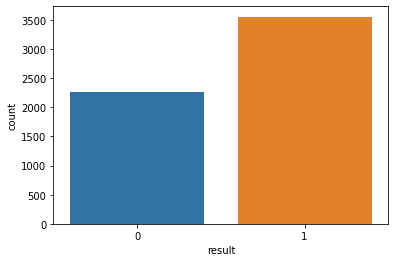

In [21]:
sns.countplot(ex_data3['result'])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


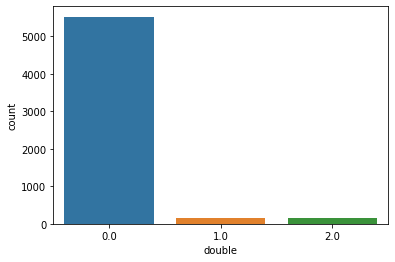

In [22]:
sns.countplot(ex_data3['double'])
plt.show()

### **home/away 구분하는 열 추가**

In [23]:
def make_home_away(data):
  data['home/away'] = ['away' if s[0] == '@' else 'home' for s in data['vs']]

  result_Dataframe = pd.DataFrame()
  result_Dataframe['name'] = data['name']
  result_Dataframe['day'] = data['day']
  result_Dataframe['double'] = data['double']
  result_Dataframe['vs'] = data['vs']
  result_Dataframe['vs_team'] = data['vs_team']
  result_Dataframe['ab'] = data['ab']
  result_Dataframe['hit'] = data['hit']
  result_Dataframe['result'] = data['result']
  result_Dataframe['home/away'] = data['home/away']
  result_Dataframe

  return result_Dataframe

In [24]:
ex_data4 = make_home_away(ex_data3)

### **home/away별 타율 구하는 과정**

In [25]:
def make_home_away_slot(data):
  data['home_ab'] = [0 if s == 'home' else 0 for s, ab in zip(data['home/away'], data['ab'])]
  data['home_hit'] = [0 if s == 'home' else 0 for s, hit in zip(data['home/away'], data['hit'])]
  data['away_ab'] = [0 if s == 'away' else 0 for s, ab in zip(data['home/away'], data['ab'])]
  data['away_hit'] = [0 if s == 'away' else 0 for s, hit in zip(data['home/away'], data['hit'])]

  result_Dataframe = pd.DataFrame()
  result_Dataframe['name'] = data['name']
  result_Dataframe['day'] = data['day']
  result_Dataframe['double'] = data['double']
  result_Dataframe['vs'] = data['vs']
  result_Dataframe['vs_team'] = data['vs_team']
  result_Dataframe['ab'] = data['ab']
  result_Dataframe['hit'] = data['hit']
  result_Dataframe['home/away'] = data['home/away']
  result_Dataframe['home_ab'] = data['home_ab']
  result_Dataframe['home_hit'] = data['home_hit']
  result_Dataframe['away_ab'] = data['away_ab']
  result_Dataframe['away_hit'] = data['away_hit']
  result_Dataframe

  return result_Dataframe  

In [26]:
ex_data5 = make_home_away_slot(ex_data4)

In [27]:
def make_home_away_ab_hit(data, batter):
  result_Dataframe = pd.DataFrame()
  for h in tqdm.tqdm(batter['name'].values): # 90명 타자 한명씩 접근
    hdata = data.loc[data['name']== h ]
    for i in range(0, len(hdata)-1):
      if hdata.iloc[i, 7] == 'home':
        hdata.iloc[i+1, 8] = hdata.iloc[i, 8] + hdata.iloc[i, 5]
        hdata.iloc[i+1, 10] = hdata.iloc[i, 10]
        hdata.iloc[i+1, 9] = hdata.iloc[i, 9] + hdata.iloc[i, 6]
        hdata.iloc[i+1, 11] = hdata.iloc[i, 11]
      else:
        hdata.iloc[i+1, 10] = hdata.iloc[i, 10] + hdata.iloc[i, 5]
        hdata.iloc[i+1, 8] = hdata.iloc[i, 8]
        hdata.iloc[i+1, 11] = hdata.iloc[i, 11] + hdata.iloc[i, 6]
        hdata.iloc[i+1, 9] = hdata.iloc[i, 9]
    result_Dataframe = pd.concat([result_Dataframe, hdata])

  return result_Dataframe


In [28]:
ex_data6 = make_home_away_ab_hit(ex_data5, batter_data_2021)

  0%|          | 0/90 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
100%|██████████| 90/90 [00:09<00:00,  9.35it/s]


In [29]:
def make_home_away_avg(data):
  data['home/away_avg'] = np.where(data['home/away'] == 'home', round(data['home_hit']/data['home_ab'],3), round(data['away_hit'] / data['away_ab'],3))

  result_Dataframe = pd.DataFrame()
  result_Dataframe['name'] = data['name']
  result_Dataframe['day'] = data['day']
  result_Dataframe['double'] = data['double']
  result_Dataframe['vs'] = data['vs']
  result_Dataframe['vs_team'] = data['vs_team']
  result_Dataframe['ab'] = data['ab']
  result_Dataframe['hit'] = data['hit']
  result_Dataframe['home/away'] = data['home/away']
  result_Dataframe['home_ab'] = data['home_ab']
  result_Dataframe['home_hit'] = data['home_hit']
  result_Dataframe['away_ab'] = data['away_ab']
  result_Dataframe['away_hit'] = data['away_hit']
  result_Dataframe['home/away_avg'] = data['home/away_avg']
  result_Dataframe['home/away_avg'].fillna(0, inplace = True)
  result_Dataframe

  return result_Dataframe  

In [30]:
hw_data = make_home_away_avg(ex_data6)
hw_data

,name,day,double,vs,vs_team,ab,hit,home/away,home_ab,home_hit,away_ab,away_hit,home/away_avg
0,강백호,20210404,0.0,한화,한화,3,2,home,0,0,0,0,0.000
1,강백호,20210406,0.0,LG,LG,4,0,home,3,2,0,0,0.667
2,강백호,20210407,0.0,LG,LG,4,3,home,7,2,0,0,0.286
3,강백호,20210408,0.0,LG,LG,4,2,home,11,5,0,0,0.455
4,강백호,20210409,0.0,@삼성,삼성,5,3,away,15,7,0,0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5815,김민하,20210623,0.0,@삼성,삼성,3,1,away,47,15,46,5,0.109
5816,김민하,20210624,0.0,@삼성,삼성,4,0,away,47,15,49,6,0.122
5817,김민하,20210626,0.0,KT,KT,1,0,home,47,15,53,6,0.319
5818,김민하,20210709,0.0,@SSG,SSG,4,1,away,48,15,53,6,0.113


### **상대 팀별 타율 구하기**

In [31]:
sort_data = ex_data3.sort_values(by=["vs_team", "name"])

In [32]:
def make_vs_slot(data):
  data['vs_ab'] = [0 if s == 'home' else 0 for s in data['home/away']]
  data['vs_hit'] = [0 if s == 'home' else 0 for s in data['home/away']]

  result_Dataframe = pd.DataFrame()
  result_Dataframe['name'] = data['name']
  result_Dataframe['day'] = data['day']
  result_Dataframe['double'] = data['double']
  result_Dataframe['vs'] = data['vs']
  result_Dataframe['vs_team'] = data['vs_team']
  result_Dataframe['ab'] = data['ab']
  result_Dataframe['hit'] = data['hit']
  result_Dataframe['result'] = data['result']
  result_Dataframe['home/away'] = data['home/away']
  result_Dataframe['vs_ab'] = data['vs_ab']
  result_Dataframe['vs_hit'] = data['vs_hit']
  result_Dataframe

  return result_Dataframe  

In [33]:
vs_data = make_vs_slot(sort_data)

In [34]:
def make_vs_ab_hit(data):
  result_Dataframe = pd.DataFrame()
  team = np.array(('KIA', 'KT', 'LG', 'SSG', 'NC', '롯데', '두산', '삼성', '키움', '한화', 'SK'))

  for t in tqdm.tqdm(team):
    vdata = data.loc[data['vs_team']== t]  
    for i in range(0, len(vdata)-1):
      if vdata.iloc[i]['name'] == vdata.iloc[i+1]['name']:
        vdata.iloc[i+1, 9] = vdata.iloc[i, 9] + vdata.iloc[i, 5] #vs_ab
        vdata.iloc[i+1, 10] = vdata.iloc[i, 10] + vdata.iloc[i, 6] #vs_hit
      else:
        vdata.iloc[i+1, 9] = 0
        vdata.iloc[i+1, 10] = 0

    result_Dataframe = pd.concat([result_Dataframe, vdata])

  return result_Dataframe

In [ ]:
pd.set_option('display.max_row', 100)
pd.set_option('display.max_columns', 100)

In [35]:
vs_ab_hit_data = make_vs_ab_hit(vs_data)

  0%|          | 0/11 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
100%|██████████| 11/11 [00:06<00:00,  1.58it/s]


In [36]:
def make_vs_avg(data):
  for i in range(0, len(data)+1):
    try:
      data['vs_avg'] = round(data['vs_hit']/data['vs_ab'], 3)
    except ZeroDivisionError:
      data['vs_avg'] = 0

  result_Dataframe = pd.DataFrame()
  result_Dataframe['name'] = data['name']
  result_Dataframe['day'] = data['day']
  result_Dataframe['double'] = data['double']
  result_Dataframe['vs'] = data['vs']
  result_Dataframe['vs_team'] = data['vs_team']
  result_Dataframe['ab'] = data['ab']
  result_Dataframe['hit'] = data['hit']
  result_Dataframe['result'] = data['result']
  result_Dataframe['home/away'] = data['home/away']
  result_Dataframe['vs_ab'] = data['vs_ab']
  result_Dataframe['vs_hit'] = data['vs_hit']
  result_Dataframe['vs_avg'] = data['vs_avg']
  result_Dataframe['vs_avg'].fillna(0, inplace = True)
  result_Dataframe

  return result_Dataframe  

In [37]:
final_vs_avg_data = make_vs_avg(vs_ab_hit_data)
final_vs_avg_data

,name,day,double,vs,vs_team,ab,hit,result,home/away,vs_ab,vs_hit,vs_avg
901,강민호,20210424,0.0,@KIA,KIA,4,2,1,away,0,0,0.000
902,강민호,20210425,0.0,@KIA,KIA,4,2,1,away,4,2,0.500
919,강민호,20210521,0.0,KIA,KIA,3,0,0,home,8,4,0.500
920,강민호,20210523,0.0,KIA,KIA,3,1,1,home,11,4,0.364
928,강민호,20210608,0.0,KIA,KIA,4,2,1,home,14,5,0.357
...,...,...,...,...,...,...,...,...,...,...,...,...
445,황재균,20210612,0.0,한화,한화,5,2,1,home,9,2,0.222
446,황재균,20210613,0.0,한화,한화,2,1,1,home,14,4,0.286
456,황재균,20210625,0.0,@한화,한화,2,0,0,away,16,5,0.312
457,황재균,20210626,0.0,@한화,한화,5,2,1,away,18,5,0.278


In [56]:
final_2021_data = pd.merge(data_2021, ex_data6, on = ['name', 'day', 'double', 'vs', 'ab', 'hit'], how = 'inner')
final_2021_data = pd.merge(final_2021_data, hw_data, on = ['name', 'day', 'double', 'vs', 'ab', 'hit'], how = 'inner')
final_2021_data = pd.merge(final_2021_data, final_vs_avg_data, on = ['name', 'day', 'double', 'vs', 'ab', 'hit'], how = 'inner')
final_2021_data

,name,day,vs,result_x,bat_order,position,start_member,ab,score,hit,2_hit,3_hit,homerun,tb,rbi,sb,cs,bb,hpp,ibb,so,gdp,sh,sf,avg,obp,slg,ops,pitch,avLI,RE24,WPA,double,vs_team_x,home/away_x,home_ab_x,home_hit_x,away_ab_x,away_hit_x,home/away_avg_x,vs_team_y,home/away_y,home_ab_y,home_hit_y,away_ab_y,away_hit_y,home/away_avg_y,vs_team,result_y,home/away,vs_ab,vs_hit,vs_avg
0,강백호,20210404,한화,W 3:2,4,1B,True,3,0,2,0,0,0,2,0,2,0,1,0,0,0,0,0,0,0.667,NaN,0.667,1.417,16,1.14,0.89,0.122,0.0,한화,home,0,0,0,0,NaN,한화,home,0,0,0,0,0.000,한화,1,home,0,0,0.000
1,강백호,20210406,LG,L 2:3,4,1B,True,4,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0.286,NaN,0.286,0.661,14,2.07,-1.00,-0.183,0.0,LG,home,3,2,0,0,0.667,LG,home,3,2,0,0,0.667,LG,0,home,0,0,0.000
2,강백호,20210407,LG,W 7:3,4,1B,True,4,0,3,0,0,0,3,1,0,0,1,0,0,0,0,0,0,0.455,NaN,0.455,0.993,17,1.43,1.75,0.330,0.0,LG,home,7,2,0,0,0.286,LG,home,7,2,0,0,0.286,LG,1,home,4,0,0.000
3,강백호,20210408,LG,L 3:7,4,1B,True,4,0,2,0,0,0,2,0,0,0,0,0,0,1,1,0,0,0.467,NaN,0.467,0.996,17,0.89,-0.76,-0.102,0.0,LG,home,11,5,0,0,0.455,LG,home,11,5,0,0,0.455,LG,1,home,8,3,0.375
4,강백호,20210409,@삼성,L 5:7,4,1B,True,5,0,3,0,1,0,5,3,0,0,0,0,0,1,1,0,0,0.500,NaN,0.600,1.145,21,0.94,1.88,-0.122,0.0,삼성,away,15,7,0,0,NaN,삼성,away,15,7,0,0,0.000,삼성,1,away,0,0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5815,김민하,20210623,@삼성,L 0:3,7,LF,True,3,0,1,0,1,0,3,0,0,1,0,0,0,0,0,0,0,0.219,NaN,0.313,0.671,7,1.10,-0.62,-0.066,0.0,삼성,away,47,15,46,5,0.109,삼성,away,47,15,46,5,0.109,삼성,1,away,10,1,0.100
5816,김민하,20210624,@삼성,L 2:3,6,RF,True,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.210,NaN,0.300,0.647,9,1.65,-1.56,-0.220,0.0,삼성,away,47,15,49,6,0.122,삼성,away,47,15,49,6,0.122,삼성,0,away,13,2,0.154
5817,김민하,20210626,KT,L 2:11,3,RF,True,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.208,NaN,0.297,0.641,7,0.01,-0.25,0.000,0.0,KT,home,47,15,53,6,0.319,KT,home,47,15,53,6,0.319,KT,0,home,7,1,0.143
5818,김민하,20210709,@SSG,D :,5,CF,True,4,0,1,0,0,0,1,1,0,0,0,1,0,3,0,0,0,0.210,NaN,0.295,0.641,19,0.68,0.40,0.036,0.0,SSG,away,48,15,53,6,0.113,SSG,away,48,15,53,6,0.113,SSG,1,away,14,0,0.000


In [57]:
len(ex_data6), len(hw_data), len(final_vs_avg_data), len(final_2021_data)

(5820, 5820, 5820, 5820)

## **최근 5일 타율** 

In [42]:
def make_recent_days(hitter_data, record_data, day=5):

  # 최근 5일(기본) 타율 저장할 공간 생성
  recent_days_avg = np.zeros(len(record_data)) # 최근 5일(기본) 경기 타율
  recent_days_hitter = np.empty(len(record_data), dtype=np.chararray) # type : 문자열 저장을 위해 chararray
  recent_days_day = np.empty(len(record_data), dtype=np.int32) # 기준이 되는 날짜
  recent_days_double = np.zeros(len(record_data), dtype=np.int8) # 더블헤더 분류 / 0 : 더블헤더 아님 / 1 : 더블헤더 1차전 / 2 : 더블헤더 2차전

  ps = 0
  for h in tqdm.tqdm(hitter_data['name']): # 90명 타자 한명씩 접근
    hdata = record_data.loc[record_data['name']==h].reset_index() # 특정 타자 한명에 대해서만 데이터 추출
    for i in range(len(hdata['day'])): # 추출한 데이터에서 한 행씩 접근
      recent_days_hitter[ps] = h # 현재 타자
      r = hdata.loc[i,'day']  # 현재 기준 날짜
      recent_days_day[ps] = r
      d = hdata.loc[i,'double'] # 현재 더블헤더 분류
      recent_days_double[ps] = d      
      if d==2: # 더블헤더 2차전이라면
        hrdata = hdata.loc[hdata['day']>=r-day].loc[hdata['day']<=r].loc[hdata['double']!=2] # r 날짜까지 가져와서 2차전을 제외
      else: # 더블헤더가 아니고, 더블헤더 1차전이라면
        hrdata = hdata.loc[hdata['day']>=r-day].loc[hdata['day']<=r-1] # 접근한 행의 날짜를 기준으로 5일(기본) 경기
         
      if len(hrdata)==0: # 최근 5일 경기 없으면 넘어가고
        ps+=1
        continue
      else : # 있으면
        sum_ab = sum(hrdata['ab'])
        if sum_ab==0: # 경기 기록은 존재하지만 타수(ab)가 0
          ps+=1
          continue
        sum_hit = sum(hrdata['hit'])
        recent_days_avg[ps] = sum_hit/sum_ab
        ps+=1

  result_Dataframe = pd.DataFrame()
  result_Dataframe['day'] = recent_days_day
  result_Dataframe['name'] = recent_days_hitter
  result_Dataframe['recent_'+str(day)+'days_avg'] = recent_days_avg
  result_Dataframe['double'] = recent_days_double

  return result_Dataframe

In [43]:
recent_5days_data = make_recent_days(batter_data_2021, data_2021, day=5)

100%|██████████| 90/90 [00:11<00:00,  7.93it/s]


In [44]:
recent_5days_data

,day,name,recent_5days_avg,double
0,20210404,강백호,0.000000,0
1,20210406,강백호,0.666667,0
2,20210407,강백호,0.285714,0
3,20210408,강백호,0.454545,0
4,20210409,강백호,0.466667,0
...,...,...,...,...
5815,20210623,김민하,0.000000,0
5816,20210624,김민하,0.100000,0
5817,20210626,김민하,0.125000,0
5818,20210709,김민하,0.000000,0


### **최근 5경기/10경기 타율**

In [45]:
def make_recent_games(hitter_data, record_data, game=5):

  # 최근 5경기(기본) 타율 저장할 공간 생성
  recent_games_avg = np.zeros(len(record_data)) # 최근 5경기(기본) 경기 타율
  recent_games_hitter = np.empty(len(record_data), dtype=np.chararray) # type : 문자열 저장을 위해 chararray
  recent_games_day = np.empty(len(record_data), dtype=np.int32) # 기준이 되는 날짜
  
  ps = 0
  for h in tqdm.tqdm(hitter_data['name']): # 90명 타자 한명씩 접근
    hdata = record_data.loc[record_data['name']==h].reset_index() # 특정 타자 한명에 대해서만 데이터 추출
    for i in range(len(hdata)): # 추출한 데이터에서 한 행씩 접근
      recent_games_hitter[ps] = h # 현재 타자
      recent_games_day[ps] = hdata.loc[i,'day'] # 현재 경기
      hrdata = hdata.loc[i-game:i-1,:] # 접근한 행의 경기를 기준으로 5경기
         
      if len(hrdata)==0: # 최근 5경기가 없으면 (첫 경기)
        ps+=1
        continue
      else : # 있으면
        sum_ab = sum(hrdata['ab'])
        if sum_ab==0: # 경기 기록은 존재하지만 타수(ab)가 0
          ps+=1
          continue
        sum_hit = sum(hrdata['hit'])
        recent_games_avg[ps] = sum_hit/sum_ab
        ps+=1

  result_Dataframe = pd.DataFrame()
  result_Dataframe['day'] = recent_games_day
  result_Dataframe['name'] = recent_games_hitter
  result_Dataframe['recent_'+str(game)+'games_avg'] = recent_games_avg

  return result_Dataframe

In [46]:
recent_5games_data = make_recent_games(batter_data_2021, data_2021, game=5)
recent_10games_data = make_recent_games(batter_data_2021, data_2021, game=10)

100%|██████████| 90/90 [00:01<00:00, 55.23it/s]


In [51]:
recent_5games_data

,day,name,recent_5games_avg
0,20210404,강백호,0.000000
1,20210406,강백호,0.666667
2,20210407,강백호,0.285714
3,20210408,강백호,0.454545
4,20210409,강백호,0.466667
...,...,...,...
5815,20210623,김민하,0.083333
5816,20210624,김민하,0.083333
5817,20210626,김민하,0.071429
5818,20210709,김민하,0.083333


In [52]:
recent_10games_data

,day,name,recent_10games_avg
0,20210404,강백호,0.000000
1,20210406,강백호,0.666667
2,20210407,강백호,0.285714
3,20210408,강백호,0.454545
4,20210409,강백호,0.466667
...,...,...,...
5815,20210623,김민하,0.136364
5816,20210624,김민하,0.142857
5817,20210626,김민하,0.120000
5818,20210709,김민하,0.130435


### **최근 10일 안타 성공률**

In [47]:
def make_success_days(hitter_data, record_data, day=10):

  # 최근 10일(기본) 안타 성공률 저장할 공간 생성
  success_days = np.zeros(len(record_data)) # 최근 10일(기본) 안타 성공률
  success_days_hitter = np.empty(len(record_data), dtype=object) # type : 문자열 저장을 위해 object
  success_days_day = np.empty(len(record_data), dtype=np.int32) # 기준이 되는 날짜
  success_days_double = np.zeros(len(record_data), dtype=np.int8) # 더블헤더 분류 / 0 : 더블헤더 아님 / 1 : 더블헤더 1차전 / 2 : 더블헤더 2차전

  ps = 0
  for h in tqdm.tqdm(hitter_data['name']): # 90명 타자 한명씩 접근
    hdata = record_data.loc[record_data['name']==h].reset_index() # 특정 타자 한명에 대해서만 데이터 추출
    for i in range(len(hdata['day'])): # 추출한 데이터에서 한 행씩 접근
      success_days_hitter[ps] = h # 현재 타자
      r = hdata.loc[i,'day']  # 현재 기준 날짜
      success_days_day[ps] = r
      d = hdata.loc[i,'double'] # 현재 더블헤더 분류
      success_days_double[ps] = d
      if d==2: # 더블헤더 2차전이라면
        hrdata = hdata.loc[hdata['day']>=r-day].loc[hdata['day']<=r].loc[hdata['double']!=2] # r 날짜까지 가져와서 2차전을 제외
      else: # 더블헤더가 아니고, 더블헤더 1차전이라면
        hrdata = hdata.loc[hdata['day']>=r-day].loc[hdata['day']<=r-1] # 접근한 행의 날짜를 기준으로 10일(기본) 경기
         
      if len(hrdata)==0: # 최근 10일(기본) 경기 없으면 넘어가고
        ps+=1
        continue
      else : # 있으면
        total = len(hrdata)
        fail = len(hrdata.loc[hrdata['hit']==0]) # 안타를 못친 경기가 몇경기나 되는지 저장
        success_days[ps] = (total-fail)/total
        ps+=1

  result_Dataframe = pd.DataFrame()
  result_Dataframe['day'] = success_days_day
  result_Dataframe['name'] = success_days_hitter
  result_Dataframe['success_'+str(day)+'days'] = success_days
  result_Dataframe['double'] = success_days_double

  return result_Dataframe

In [48]:
success_10days_data = make_success_days(batter_data_2021, data_2021, day=10)

100%|██████████| 90/90 [00:14<00:00,  6.14it/s]


In [53]:
success_10days_data

,day,name,success_10days,double
0,20210404,강백호,0.000000,0
1,20210406,강백호,1.000000,0
2,20210407,강백호,0.500000,0
3,20210408,강백호,0.666667,0
4,20210409,강백호,0.750000,0
...,...,...,...,...
5815,20210623,김민하,0.285714,0
5816,20210624,김민하,0.428571,0
5817,20210626,김민하,0.285714,0
5818,20210709,김민하,0.000000,0


### **최근 10경기 안타 성공률**

In [49]:
def make_success_games(hitter_data, record_data, game=10):

  # 최근 10경기(기본) 안타 성공률 저장할 공간 생성
  success_games = np.zeros(len(record_data)) # 최근 10경기(기본) 안타 성공률
  success_games_hitter = np.empty(len(record_data), dtype=object) # type : 문자열 저장을 위해 object
  success_games_day = np.empty(len(record_data), dtype=np.int32) # 기준이 되는 날짜
  
  ps = 0
  for h in tqdm.tqdm(hitter_data['name']): # 90명 타자 한명씩 접근
    hdata = record_data.loc[record_data['name']==h].reset_index() # 특정 타자 한명에 대해서만 데이터 추출
    for i in range(len(hdata)): # 추출한 데이터에서 한 행씩 접근
      success_games_hitter[ps] = h # 현재 타자
      success_games_day[ps] = hdata.loc[i,'day'] # 현재 경기
      hrdata = hdata.loc[i-game:i-1,:] # 접근한 행의 경기를 기준으로 10경기(기본)
         
      if len(hrdata)==0: # 최근 10경기(기본)가 없으면 (첫 경기)
        ps+=1
        continue
      else : # 있으면
        total = len(hrdata)
        fail = len(hrdata.loc[hrdata['hit']==0]) # 안타를 못친 경기가 몇경기나 되는지 저장
        success_games[ps] = (total-fail)/total
        ps+=1

  result_Dataframe = pd.DataFrame()
  result_Dataframe['day'] = success_games_day
  result_Dataframe['name'] = success_games_hitter
  result_Dataframe['success_'+str(game)+'games'] = success_games

  return result_Dataframe

In [50]:
success_10games_data = make_success_games(batter_data_2021, data_2021, game=10)

100%|██████████| 90/90 [00:06<00:00, 14.29it/s]


In [54]:
success_10games_data

,day,name,success_10games
0,20210404,강백호,0.000000
1,20210406,강백호,1.000000
2,20210407,강백호,0.500000
3,20210408,강백호,0.666667
4,20210409,강백호,0.750000
...,...,...,...
5815,20210623,김민하,0.300000
5816,20210624,김민하,0.300000
5817,20210626,김민하,0.300000
5818,20210709,김민하,0.300000


In [59]:
final_2021_data = pd.merge(final_2021_data, recent_5days_data, on = ['name', 'day', 'double'], how = 'inner')
# final_2021_data = pd.merge(final_2021_data, recent_5games_data, on = ['name', 'day'], how = 'inner')
# final_2021_data = pd.merge(final_2021_data, recent_10games_data, on = ['name', 'day'], how = 'inner')
final_2021_data = pd.merge(final_2021_data, success_10days_data, on = ['name', 'day', 'double'], how = 'inner')
# final_2021_data = pd.merge(final_2021_data, success_10games_data, on = ['name', 'day'], how = 'inner')

In [64]:
final_2021_data

,name,day,vs,result_x,bat_order,position,start_member,ab,score,hit,2_hit,3_hit,homerun,tb,rbi,sb,cs,bb,hpp,ibb,so,gdp,sh,sf,avg,obp,slg,ops,pitch,avLI,RE24,WPA,double,vs_team_x,home/away_x,home_ab_x,home_hit_x,away_ab_x,away_hit_x,home/away_avg_x,vs_team_y,home/away_y,home_ab_y,home_hit_y,away_ab_y,away_hit_y,home/away_avg_y,vs_team,result_y,home/away,vs_ab,vs_hit,vs_avg,recent_5days_avg,success_10days
0,강백호,20210404,한화,W 3:2,4,1B,True,3,0,2,0,0,0,2,0,2,0,1,0,0,0,0,0,0,0.667,NaN,0.667,1.417,16,1.14,0.89,0.122,0.0,한화,home,0,0,0,0,NaN,한화,home,0,0,0,0,0.000,한화,1,home,0,0,0.000,0.000000,0.000000
1,강백호,20210406,LG,L 2:3,4,1B,True,4,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0.286,NaN,0.286,0.661,14,2.07,-1.00,-0.183,0.0,LG,home,3,2,0,0,0.667,LG,home,3,2,0,0,0.667,LG,0,home,0,0,0.000,0.666667,1.000000
2,강백호,20210407,LG,W 7:3,4,1B,True,4,0,3,0,0,0,3,1,0,0,1,0,0,0,0,0,0,0.455,NaN,0.455,0.993,17,1.43,1.75,0.330,0.0,LG,home,7,2,0,0,0.286,LG,home,7,2,0,0,0.286,LG,1,home,4,0,0.000,0.285714,0.500000
3,강백호,20210408,LG,L 3:7,4,1B,True,4,0,2,0,0,0,2,0,0,0,0,0,0,1,1,0,0,0.467,NaN,0.467,0.996,17,0.89,-0.76,-0.102,0.0,LG,home,11,5,0,0,0.455,LG,home,11,5,0,0,0.455,LG,1,home,8,3,0.375,0.454545,0.666667
4,강백호,20210409,@삼성,L 5:7,4,1B,True,5,0,3,0,1,0,5,3,0,0,0,0,0,1,1,0,0,0.500,NaN,0.600,1.145,21,0.94,1.88,-0.122,0.0,삼성,away,15,7,0,0,NaN,삼성,away,15,7,0,0,0.000,삼성,1,away,0,0,0.000,0.466667,0.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5815,김민하,20210623,@삼성,L 0:3,7,LF,True,3,0,1,0,1,0,3,0,0,1,0,0,0,0,0,0,0,0.219,NaN,0.313,0.671,7,1.10,-0.62,-0.066,0.0,삼성,away,47,15,46,5,0.109,삼성,away,47,15,46,5,0.109,삼성,1,away,10,1,0.100,0.000000,0.285714
5816,김민하,20210624,@삼성,L 2:3,6,RF,True,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.210,NaN,0.300,0.647,9,1.65,-1.56,-0.220,0.0,삼성,away,47,15,49,6,0.122,삼성,away,47,15,49,6,0.122,삼성,0,away,13,2,0.154,0.100000,0.428571
5817,김민하,20210626,KT,L 2:11,3,RF,True,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.208,NaN,0.297,0.641,7,0.01,-0.25,0.000,0.0,KT,home,47,15,53,6,0.319,KT,home,47,15,53,6,0.319,KT,0,home,7,1,0.143,0.125000,0.285714
5818,김민하,20210709,@SSG,D :,5,CF,True,4,0,1,0,0,0,1,1,0,0,0,1,0,3,0,0,0,0.210,NaN,0.295,0.641,19,0.68,0.40,0.036,0.0,SSG,away,48,15,53,6,0.113,SSG,away,48,15,53,6,0.113,SSG,1,away,14,0,0.000,0.000000,0.000000


### **Multi layer Perceptron in Be the legend**

In [65]:
mlp_data = final_2021_data.loc[:, ['name', 'vs_team', 'avg', 'slg', 'ops', 'home/away_avg_y', 'vs_ab', 'vs_hit', 'vs_avg', 'recent_5days_avg','success_10days', 'result_y']]

In [66]:
mlp_data

,name,vs_team,avg,slg,ops,home/away_avg_y,vs_ab,vs_hit,vs_avg,recent_5days_avg,success_10days,result_y
0,강백호,한화,0.667,0.667,1.417,0.000,0,0,0.000,0.000000,0.000000,1
1,강백호,LG,0.286,0.286,0.661,0.667,0,0,0.000,0.666667,1.000000,0
2,강백호,LG,0.455,0.455,0.993,0.286,4,0,0.000,0.285714,0.500000,1
3,강백호,LG,0.467,0.467,0.996,0.455,8,3,0.375,0.454545,0.666667,1
4,강백호,삼성,0.500,0.600,1.145,0.000,0,0,0.000,0.466667,0.750000,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5815,김민하,삼성,0.219,0.313,0.671,0.109,10,1,0.100,0.000000,0.285714,1
5816,김민하,삼성,0.210,0.300,0.647,0.122,13,2,0.154,0.100000,0.428571,0
5817,김민하,KT,0.208,0.297,0.641,0.319,7,1,0.143,0.125000,0.285714,0
5818,김민하,SSG,0.210,0.295,0.641,0.113,14,0,0.000,0.000000,0.000000,1


In [67]:
from keras.utils.np_utils import to_categorical
import numpy as np
from sklearn.preprocessing import minmax_scale
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [68]:
mlp_train, mlp_test = train_test_split(mlp_data, test_size=0.2, random_state=30)

In [69]:
X_train = mlp_train.loc[:, ['avg', 'slg', 'ops', 'home/away_avg_y', 'vs_ab', 'vs_hit', 'vs_avg', 'recent_5days_avg','success_10days']]
y_train = mlp_train.loc[:, ['result_y']]

X_test = mlp_test.loc[:, ['avg', 'slg', 'ops', 'home/away_avg_y', 'vs_ab', 'vs_hit', 'vs_avg', 'recent_5days_avg','success_10days',]]
y_test = mlp_test.loc[:, ['result_y']]

In [70]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

In [71]:
number_of_train_samples = X_train.shape[0]
width = X_train.shape[1]
X_train = X_train.reshape(number_of_train_samples, width)

In [72]:
number_of_test_samples = X_test.shape[0]
X_test = X_test.reshape(number_of_test_samples, width)

In [73]:
X_train = minmax_scale(X_train, feature_range=(0,1), axis = 0)
X_test = minmax_scale(X_test, feature_range=(0,1), axis = 0)

In [74]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [75]:
model = Sequential()

model.add(Dense(512, input_dim= width, kernel_initializer = 'glorot_uniform', activation = 'relu'))
# model.add(Dropout(0.3))
model.add(Dense(300, kernel_initializer = 'glorot_uniform', activation = 'relu'))
model.add(Dense(256, kernel_initializer = 'glorot_uniform', activation = 'relu'))

model.add(Dense(128, kernel_initializer = 'glorot_uniform', activation = 'relu'))

model.add(Dense(64, kernel_initializer = 'glorot_uniform', activation = 'relu'))

model.add(Dense(32, kernel_initializer = 'glorot_uniform', activation = 'relu'))
model.add(Dense(16, kernel_initializer = 'glorot_uniform', activation = 'relu'))
model.add(Dense(2, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [76]:
hist = model.fit(X_train, y_train, epochs= 100, batch_size = 32)

Epoch 1/100
146/146 [==============================] - 15s 5ms/step - loss: 0.6795 - accuracy: 0.6128
Epoch 2/100
146/146 [==============================] - 1s 5ms/step - loss: 0.6614 - accuracy: 0.6280
Epoch 3/100
146/146 [==============================] - 1s 5ms/step - loss: 0.6626 - accuracy: 0.6215
Epoch 4/100
146/146 [==============================] - 1s 5ms/step - loss: 0.6611 - accuracy: 0.6248
Epoch 5/100
146/146 [==============================] - 1s 7ms/step - loss: 0.6657 - accuracy: 0.6138
Epoch 6/100
146/146 [==============================] - 1s 5ms/step - loss: 0.6694 - accuracy: 0.6058
Epoch 7/100
146/146 [==============================] - 1s 5ms/step - loss: 0.6677 - accuracy: 0.6094
Epoch 8/100
146/146 [==============================] - 1s 5ms/step - loss: 0.6679 - accuracy: 0.6089
Epoch 9/100
146/146 [==============================] - 1s 5ms/step - loss: 0.6665 - accuracy: 0.6106
Epoch 10/100
146/146 [==============================] - 1s 5ms/step - loss: 0.6600 - accur

In [77]:
loss_and_metrics = model.evaluate(X_test, y_test, batch_size = 32)

37/37 [==============================] - 2s 4ms/step - loss: 0.7810 - accuracy: 0.6177
